In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

# Load and plot data

In [2]:
df = pd.read_csv("data/data-ZIP.txt")
print(len(df))
df.head(5)

200


,Sex,Sake,Age,Y
0,0,1,18,5
1,1,0,18,2
2,1,1,18,1
3,0,0,19,3
4,0,0,19,5


In [3]:
df.nunique()

Sex      2
Sake     2
Age     38
Y       16
dtype: int64

In [4]:
df["Sex"].value_counts()

0    122
1     78
Name: Sex, dtype: int64

In [5]:
df["Sake"].value_counts()

0    139
1     61
Name: Sake, dtype: int64

In [6]:
df.loc[:, ["Age", "Y"]].describe()

,Age,Y
count,200.000000,200.000000
mean,36.725000,4.195000
std,10.413529,4.064428
min,18.000000,0.000000
25%,28.000000,0.000000
50%,36.000000,4.000000
75%,45.250000,7.000000
max,55.000000,17.000000


In [7]:
def hist_density_plot(ax, data, col_name):
    sns.histplot(ax=ax, data=data, stat="density", x=col_name)
    sns.kdeplot(ax=ax, data=data, x=col_name, color='k')
    ax.set_xlim(data[col_name].min(), data[col_name].max())

def box_strip_plot(ax, data, x, y):
    sns.boxplot(ax=ax, data=data, x=x, y=y, dodge=False)
    sns.stripplot(ax=ax, data=data, x=x, y=y, size=8, edgecolors='k', linewidth=1)
    
def scatter_plot(ax, data, x, y):
    sns.scatterplot(
        ax=ax, 
        data=data, x=x, y=y,
        s=64,
        edgecolor='k', linewidths=10
    )
    
def crosstab_plot(ax, data, x, y):
    val = pd.crosstab(data[x], data[y]).values
    maxval = np.sqrt(val.max())
    
    for i in range(val.shape[0]):
        for j in range(val.shape[1]):
            r = 0.4 * np.sqrt(val[i, j])/ maxval
            ax.add_artist(plt.Circle((i, j), r) )
            ax.text(i, j, val[i, j], horizontalalignment='center',verticalalignment='center', fontsize=30)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xlim(-0.5, val.shape[0] - 0.5)
    ax.set_ylim(-0.5, val.shape[1] - 0.5)
    ax.set_aspect("equal")

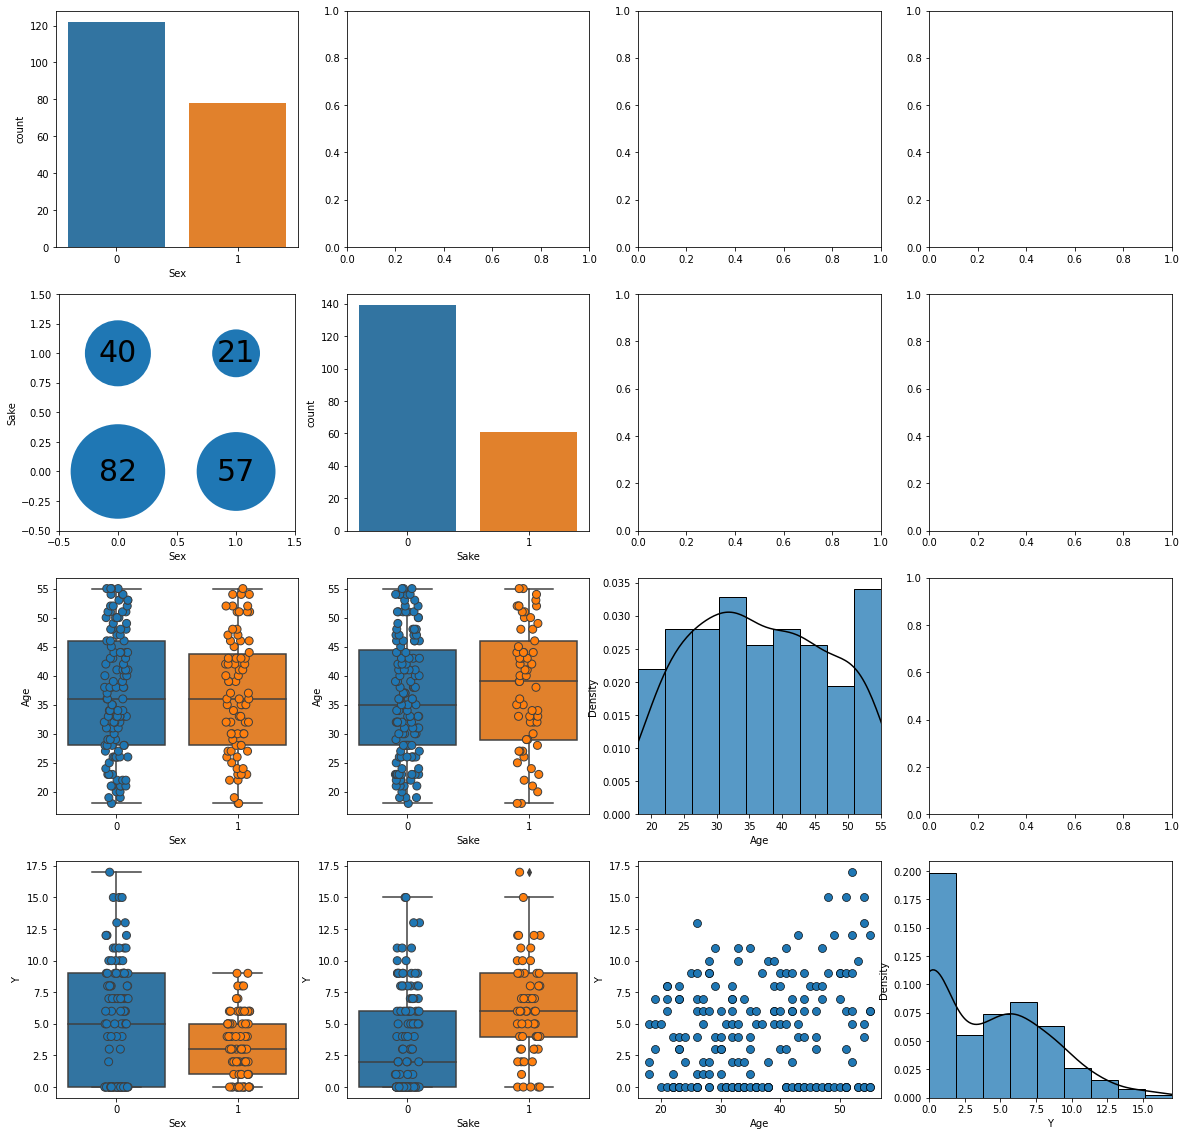

In [8]:
# Fig 11.4
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20))

# Sex
sns.countplot(ax=axes[0, 0], data=df, x="Sex")

# Sake
crosstab_plot(axes[1, 0], data=df, x="Sex", y="Sake")
sns.countplot(ax=axes[1, 1], data=df, x="Sake")

# Age
box_strip_plot(ax=axes[2, 0], data=df, x="Sex", y="Age")
box_strip_plot(ax=axes[2, 1], data=df, x="Sake", y="Age")
hist_density_plot(ax=axes[2, 2], data=df, col_name="Age")

# Y
box_strip_plot(ax=axes[3, 0], data=df, x="Sex", y="Y")
box_strip_plot(ax=axes[3, 1], data=df, x="Sake", y="Y")
scatter_plot(ax=axes[3, 2], data=df, x="Age", y="Y")
hist_density_plot(ax=axes[3, 3], data=df, col_name="Y")

# Run Stan

In [9]:
model = CmdStanModel(stan_file="model/model11-7.stan")
print(model)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workdir/chap11/model/model11-7


CmdStanModel: name=model11-7
	 stan_file=/workdir/chap11/model/model11-7.stan
	 exe_file=/workdir/chap11/model/model11-7
	 compiler_optons=stanc_options=None, cpp_options=None


In [11]:
X = np.zeros(df.shape)
X[:, 0] = np.ones(len(X))
X[:, 1] = df["Sex"]
X[:, 2] = df["Sake"]
X[:, 3] = df["Age"] / 10

data = {
    "N": df.shape[0],
    "D": df.shape[1],
    "Y": df["Y"].values,
    "X": X
}

In [12]:
fit = model.sample(data=data, show_progress=True)

Chain 1 - warmup:   0%|          | 0/2000 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/2000 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/2000 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|          | 0/2000 [00:00<?, ?it/s]

Chain 3 - warmup:   5%|▌         | 100/2000 [00:00<00:10, 173.02it/s]


Chain 2 - warmup:   5%|▌         | 100/2000 [00:00<00:15, 120.34it/s]

Chain 3 - warmup:  10%|█         | 200/2000 [00:00<00:08, 212.52it/s]


Chain 1 - warmup:  15%|█▌        | 300/2000 [00:01<00:07, 231.79it/s]


Chain 2 - warmup:  10%|█         | 200/2000 [00:01<00:11, 155.87it/s]

Chain 1 - warmup:  20%|██        | 400/2000 [00:01<00:05, 290.18it/s]


Chain 4 - warmup:  20%|██        | 400/2000 [00:01<00:05, 316.78it/s]

Chain 1 - warmup:  25%|██▌       | 500/2000 [00:01<00:04, 346.88it/s]


Chain 2 - war

In [13]:
fit.summary().loc[["b[1,1]", "b[1,2]", "b[1,3]","b[1,4]","b[2,1]","b[2,2]","b[2,3]","b[2,4]"]]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
"b[1,1]",0.94,0.01200,0.680,-0.15,0.94,2.100,3169.0,376.0,1.0
"b[1,2]",1.60,0.00660,0.430,0.92,1.60,2.300,4229.0,502.0,1.0
"b[1,3]",3.60,0.29000,2.500,2.20,3.30,5.000,76.0,9.0,1.1
"b[1,4]",-0.36,0.00320,0.180,-0.66,-0.36,-0.078,3125.0,371.0,1.0
"b[2,1]",1.40,0.00230,0.140,1.20,1.40,1.700,3529.0,419.0,1.0
"b[2,2]",-0.75,0.00120,0.080,-0.88,-0.75,-0.620,4215.0,500.0,1.0
"b[2,3]",-0.16,0.00120,0.074,-0.28,-0.16,-0.040,3856.0,458.0,1.0
"b[2,4]",0.20,0.00056,0.033,0.14,0.20,0.250,3507.0,416.0,1.0


In [14]:
q_samples = fit.stan_variable("q")
lambda_samples = fit.stan_variable("lambda")

r = np.zeros(fit.chains * fit.num_draws)
for i in range(len(r)):
    r[i] = spearmanr(q_samples[i], lambda_samples[i]).correlation
    
np.percentile(r, [50.0, 5.0, 95.0], axis=0)

array([-0.6485154 , -0.77206526, -0.52040903])